# What are the chances of making a loss on the MSCI index?

In [1]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange
import scipy

## Simple DCA calculation

In [2]:
@njit
def dca_return(
    years: int,
    amount_invested: float,
    annual_return: float,
    frequency: int = 12,
) -> tuple[NDArray, NDArray]:
    invested = np.empty(years, np.float64)
    value = np.empty(years, np.float64)

    current_investment = 0
    current_value = 0

    period_return = (1 + annual_return / frequency)
    
    for year in range(years):
        for _ in range(frequency):
            current_investment += amount_invested
            current_value += amount_invested
            current_value *= period_return
        
        invested[year] = current_investment
        value[year] = current_value

    return invested, value

In [3]:
n_years = 30
invested_dca, value_dca = dca_return(years=n_years, amount_invested=1000, annual_return=0.07)
years = np.arange(1, n_years + 1)

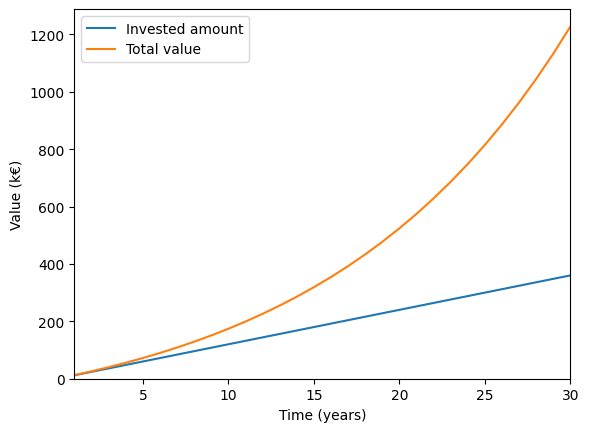

In [4]:
fig, ax = plt.subplots(1)
ax.plot(years, invested_dca / 1000, label = "Invested amount")
ax.plot(years, value_dca / 1000, label = "Total value")
ax.set_xlim(1, n_years)
ax.set_ylim(0, None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Value (k€)")
ax.legend()

# fig.savefig("dca_1000_007.png")

## Data based analysis of MSCI world index

Sourcing of the data: https://curvo.eu/backtest/en/market-index/msci-world?currency=eur

In [5]:
msci = pd.read_csv("data/MSCU World historical barcharts.csv")
msci["Date"] = pd.to_datetime(msci["Date"])
msci = msci.rename(columns={"MSCI World": "Value"})
msci["Change"] = msci["Value"].diff() / msci["Value"]
msci

,Date,Value,Change
0,1978-12-01,10000.000000,NaN
1,1979-01-01,10398.930905,0.038363
2,1979-02-01,10248.849017,-0.014644
3,1979-03-01,10675.226278,0.039941
4,1979-04-01,10778.503583,0.009582
...,...,...,...
535,2023-07-01,756955.833830,0.018522
536,2023-08-01,749413.271188,-0.010065
537,2023-09-01,735631.236909,-0.018735
538,2023-10-01,712604.679422,-0.032313


### Basic data exploration

(0.0, 794524.65993272)

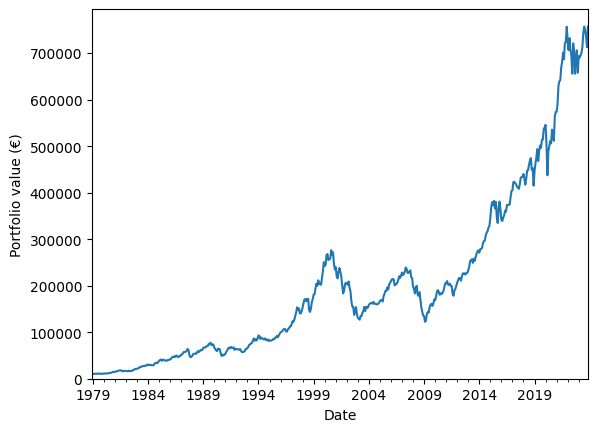

In [6]:
fig, ax = plt.subplots(1)

msci.plot(x="Date", y="Value", ax=ax)
ax.set_ylabel("Portfolio value (€)")
ax.get_legend().remove()
ax.set_ylim(0, None)

# fig.savefig("msci_value.png")

Total number of data points: 540
Mean: 0.7054077339220541 %
Median: 1.1755638169348852 %


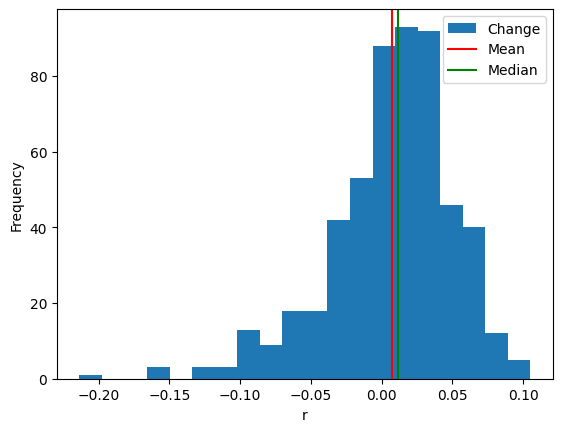

In [7]:
print("Total number of data points:", len(msci))

# Some basic descriptive statistics
mean = msci["Change"].mean()
median = msci["Change"].median()

print("Mean:", mean * 100, "%")
print("Median:", median * 100, "%")

ax = msci["Change"].plot.hist(bins=20)
ax.axvline(mean, label="Mean", color="red")
ax.axvline(median, label="Median", color="green")

ax.set_xlabel("r")
ax.legend()

# ax.figure.savefig("histogram_market.png")

## Monte carlo simulations

Assumptions:
* selection of r each month is an independent event
* the distribution from which r is drawn is static

In [8]:
@njit
def bootstrap(sample: NDArray) -> NDArray:
    n_samples = len(sample)
    indexes = np.random.randint(low=0, high=n_samples, size=n_samples)
    return sample[indexes]
    
def dca_invested(n_years: int, monthly_investment) -> NDArray:
    return (np.arange(n_years) + 1) * 12 * monthly_investment

@njit
def performant_monte_carlo(
    n_years: int,
    monthly_investment: float,
    history: NDArray,
    n_bootstraps: int, 
    n_sims_per_bootstrap: int,
) -> NDArray:
    results = np.empty((n_bootstraps, n_sims_per_bootstrap, n_years), dtype=float)

    for bs in prange(n_bootstraps):
        bootstrapped_history = bootstrap(history)
        
        for sim_num in range(n_sims_per_bootstrap):
            value = 0.
            net_monthly_investment = monthly_investment  # 0 cost
            
            for year in range(n_years):
                for month in range(12):
                    value += net_monthly_investment
                    value *= (1 + np.random.choice(bootstrapped_history))
    
                # ensure we don't go negative
                value = max(value, 0)
                
                results[bs, sim_num, year] = value
            
    return results

In [9]:
%%time

n_years = 30
monthly_investment = 1000
n_bootstraps = 5000
n_sims_per_bootstrap = 2000

history = msci["Change"].iloc[1:].values  # skip the first Nan value
years = np.arange(1, n_years + 1)
value = performant_monte_carlo(
    n_years=n_years,
    monthly_investment=monthly_investment,
    history=history,
    n_bootstraps=n_bootstraps,
    n_sims_per_bootstrap=n_sims_per_bootstrap,
)

invested = dca_invested(n_years, monthly_investment)

CPU times: user 1min 2s, sys: 319 ms, total: 1min 3s
Wall time: 1min 3s


In [10]:
final_value = value[:, :, -1]
final_invested = invested[-1]
chance_to_lose = np.sum((final_value < final_invested), axis=1) / final_value.shape[1] * 100
print(chance_to_lose.mean())

3.2947699999999998


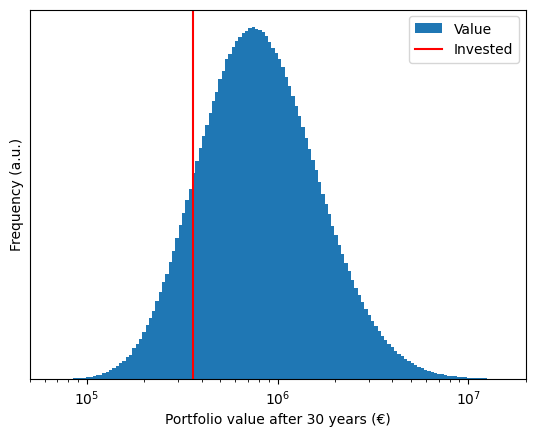

In [11]:
flat_value = final_value.ravel()
fig, ax = plt.subplots()
bins = np.geomspace(flat_value.min(), flat_value.max(), 200)
_ = ax.hist(flat_value, bins=bins, density=True, label="Value")
ax.axvline(final_invested, color="red", label="Invested")
ax.set_xscale("log")
ax.set_xlabel("Portfolio value after 30 years (€)")
ax.set_ylabel("Frequency (a.u.)")

ax.set_yticks([])

ax.set_xlim(5e4, 2e7)
ax.legend()

# fig.savefig("result_mc.png")

In [12]:
median_value = np.median(value, axis=(0, 1))
mean_value = np.mean(value, axis=(0, 1))

In [13]:
all_sims_matrix = value.reshape(-1, 30)
is_loss_making = all_sims_matrix < invested
chance_of_loss = is_loss_making.sum(axis=0) / is_loss_making.shape[0]

Text(0, 0.5, 'Probability of making a loss')

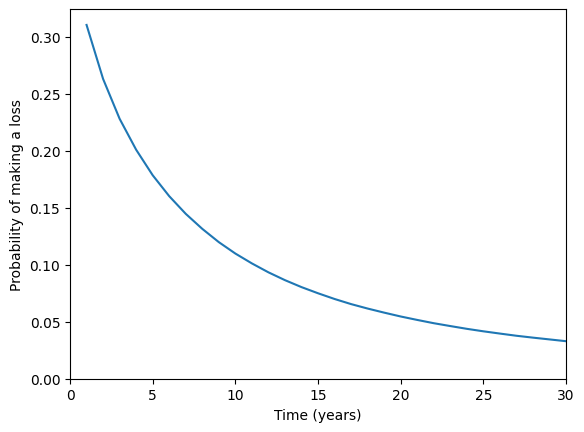

In [14]:
fig, ax = plt.subplots(1)

ax.plot(years, chance_of_loss)
ax.set_xlim(0, 30)
ax.set_ylim(0, None)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Probability of making a loss")

# fig.savefig("chance_making_loss.png")

In [15]:
# median value after 30 years
median_value[-1]

1355544.5419582692

In [16]:
# mean value after 30 years
mean_value[-1]

1868067.6941603324

In [17]:
# chance of doubling your money
1 - scipy.stats.percentileofscore(flat_value, 360000*2)

-18.868750000000002

In [18]:
def equivalent_dca_interest_rate(
    multiplier: float,
    years: int,
) -> float:
    coef = np.ones(years)
    coef[0] -= multiplier * years
    polynomial = np.polynomial.polynomial.Polynomial(coef)
    roots = polynomial.roots() - 1
    real_roots = roots[roots.imag == 0].real
    assert len(real_roots) == 1
    return real_roots[0]

In [19]:
print(equivalent_dca_interest_rate(1350000 / 360000, 30))
print(equivalent_dca_interest_rate(1860000 / 360000, 30))

0.07962164396882487
0.09685281629319631


# Verifying assumptions

## Is future r correlated with past r?

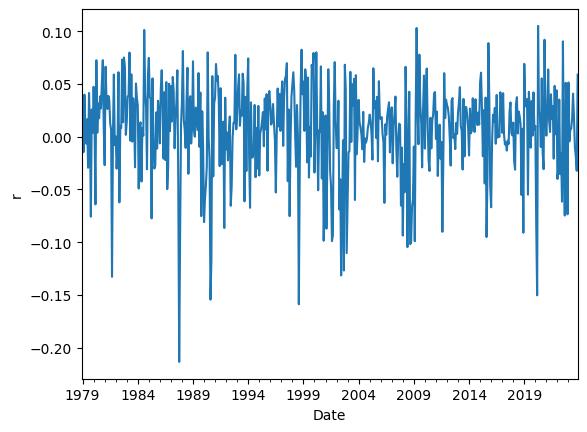

In [20]:
fig, ax = plt.subplots(1)

msci.plot(x="Date", y="Change", ax=ax)
ax.set_ylabel("r")
ax.get_legend().remove()

# fig.savefig("change_over_time.png")

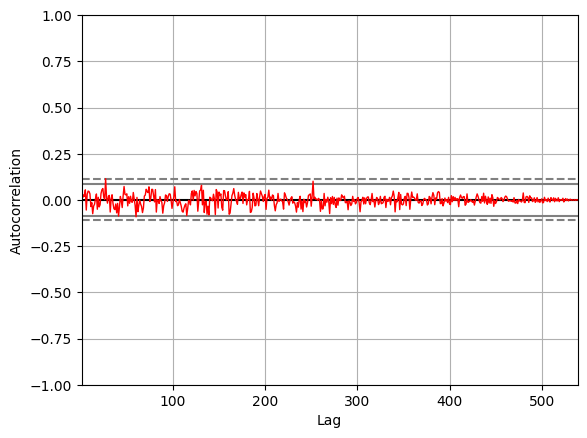

In [21]:
start = 1  # consider everything
#start = -300  # only consider last 25 years
ax = pd.plotting.autocorrelation_plot(msci["Change"].iloc[start:], color="red", lw=1)

# ax.figure.savefig("autocorrelation.png")

## Is the distribution of r constant over time?

#### Periodic effect

In [22]:
split_by_months = {}

for month in range(1, 13):
    msci_nonan = msci.iloc[1:]
    selection = pd.DatetimeIndex(msci_nonan["Date"]).month == month
    split_by_months[month] = msci_nonan[selection]

In [23]:
ks_results = np.ones((12, 12))

for month_1 in range(1, 13):
    for month_2 in range(month_1 + 1, 13):
        data_1 = split_by_months[month_1]["Change"]
        data_2 = split_by_months[month_2]["Change"]
        result = scipy.stats.ks_2samp(data_1, data_2)
        ks_results[month_1 - 1, month_2 - 1] = result.pvalue
        ks_results[month_2 - 1, month_1 - 1] = result.pvalue

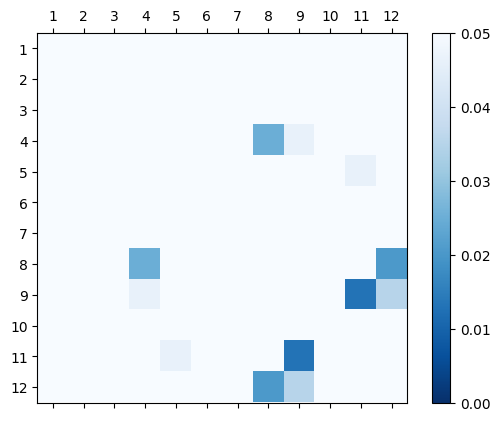

In [24]:
fig, ax = plt.subplots(1)

matrix = ax.matshow(ks_results, cmap="Blues_r", vmin=0, vmax=0.05)
ax.set_xticks(range(12), labels=range(1, 13))
ax.set_yticks(range(12), labels=range(1, 13))
cb = ax.figure.colorbar(matrix, )

# fig.savefig("ks_months.png")

Month: 9
Mean: -1.2184909315773342 %
Median: 0.2692559364298318 %
Month: 11
Mean: 1.5987520756067595 %
Median: 2.419221667481323 %


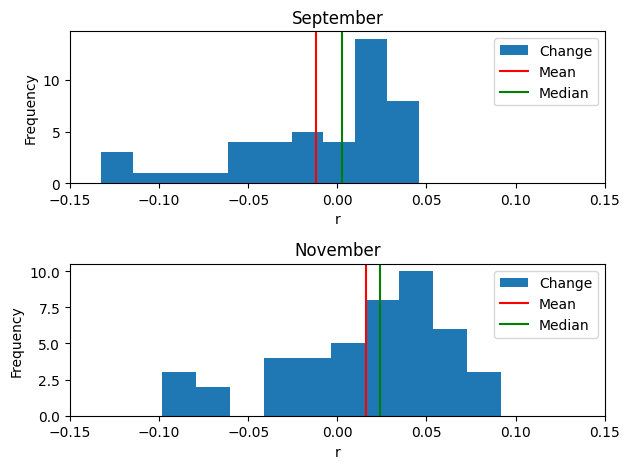

In [25]:
def plot_month_histogram(ax, month: int, bins: int = 10) -> None:
    data = split_by_months[month]["Change"]
    mean = data.mean()
    median = data.median()
    
    print("Month:", month)
    print("Mean:", mean * 100, "%")
    print("Median:", median * 100, "%")
    
    ax = data.plot.hist(bins=bins, ax = ax)
    ax.axvline(mean, label="Mean", color="red")
    ax.axvline(median, label="Median", color="green")
    ax.set_xlim(-0.15, 0.15)
    
    ax.set_xlabel("r")
    ax.legend()


fig, ax = plt.subplots(2)

plot_month_histogram(ax[0], 9)
plot_month_histogram(ax[1], 11)

ax[0].set_title("September")
ax[1].set_title("November")

fig.tight_layout()

# fig.savefig("compare_months.png")

In [26]:
scipy.stats.binom.sf(6, 66, 0.05)

0.04641626104099855

#### Comparing decades

In [27]:
split_by_block = {}

decades = (1980, 1990, 2000, 2010, 2020)
for decade in decades:
    msci_nonan = msci.iloc[1:]
    year = pd.DatetimeIndex(msci_nonan["Date"]).year
    selection = (year >= decade) & (year < decade + 10)
    split_by_block[decade] = msci_nonan[selection]

In [28]:
ks_results = np.ones((5, 5))

for decade_1_i in range(5):
    for decade_2_i in range(decade_1_i + 1, 5):
        decade_1 = decades[decade_1_i - 1]
        decade_2 = decades[decade_2_i - 1]
        data_1 = split_by_block[decade_1]["Change"]
        data_2 = split_by_block[decade_2]["Change"]
        result = scipy.stats.ks_2samp(data_1, data_2)
        ks_results[decade_1_i, decade_2_i] = result.pvalue
        ks_results[decade_2_i, decade_1_i] = result.pvalue

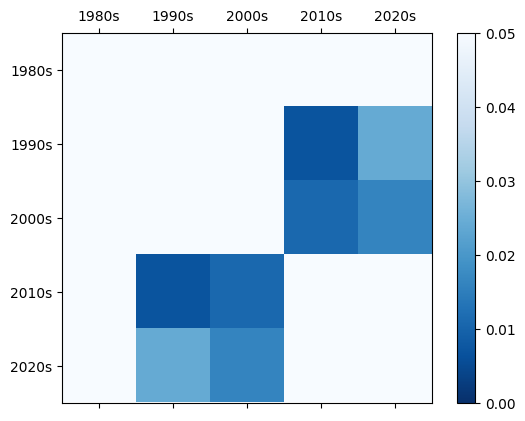

In [29]:
fig, ax = plt.subplots(1)

matrix = ax.matshow(ks_results, cmap="Blues_r", vmin=0, vmax=0.05)
ax.set_xticks(range(len(decades)), labels=(f"{d}s" for d in decades))
ax.set_yticks(range(len(decades)), labels=(f"{d}s" for d in decades))
cb = ax.figure.colorbar(matrix)

# fig.savefig("ks_decades.png")

Decade: 2000
Mean: -0.43579112097070466 %
Median: 0.3678671165601337 %
Decade: 2010
Mean: 0.9075922952979895 %
Median: 1.212226204273682 %


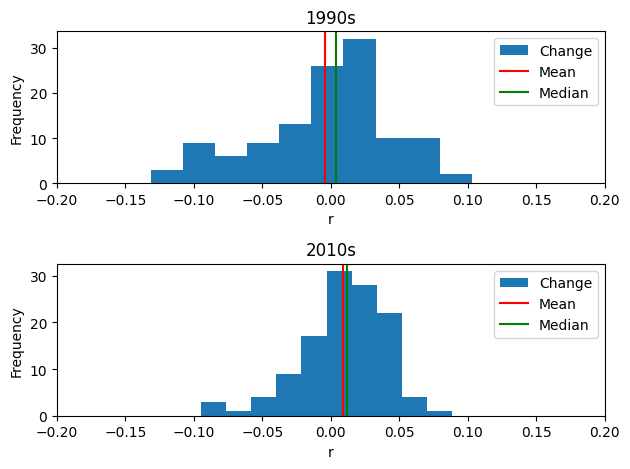

In [30]:
def plot_decade_histogram(ax, decade: int, bins: int = 10) -> None:
    data = split_by_block[decade]["Change"]
    mean = data.mean()
    median = data.median()
    
    print("Decade:", decade)
    print("Mean:", mean * 100, "%")
    print("Median:", median * 100, "%")
    
    ax = data.plot.hist(bins=bins, ax = ax)
    ax.axvline(mean, label="Mean", color="red")
    ax.axvline(median, label="Median", color="green")
    ax.set_xlim(-0.2, 0.2)
    
    ax.set_xlabel("r")
    ax.legend()


fig, ax = plt.subplots(2)

plot_decade_histogram(ax[0], 2000)
plot_decade_histogram(ax[1], 2010)

ax[0].set_title("1990s")
ax[1].set_title("2010s")

fig.tight_layout()

#fig.savefig("compare_decades.png")

#### Repeating the calculation using a subset of the history

In [31]:
%%time

n_years = 30
monthly_investment = 1000
n_bootstraps = 5000
n_sims_per_bootstrap = 2000

# only consider data from 1990 to 2010
data_years = pd.DatetimeIndex(msci["Date"]).year
selection = (data_years >= 1990) & (data_years < 2010)
history = msci["Change"][selection].values
years = np.arange(1, n_years + 1)
value = performant_monte_carlo(
    n_years=n_years,
    monthly_investment=monthly_investment,
    history=history,
    n_bootstraps=n_bootstraps,
    n_sims_per_bootstrap=n_sims_per_bootstrap,
)

invested = dca_invested(n_years, monthly_investment)

CPU times: user 27.4 s, sys: 286 ms, total: 27.7 s
Wall time: 27.6 s


In [32]:
final_value = value[:, :, -1]
final_invested = invested[-1]
chance_to_lose = np.sum((final_value < final_invested), axis=1) / final_value.shape[1] * 100
print(chance_to_lose.mean())

35.86073


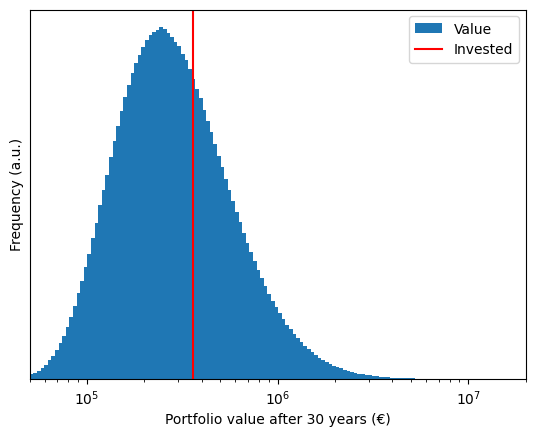

In [33]:
flat_value = final_value.ravel()
fig, ax = plt.subplots()
bins = np.geomspace(flat_value.min(), flat_value.max(), 200)
_ = ax.hist(flat_value, bins=bins, density=True, label="Value")
ax.axvline(final_invested, color="red", label="Invested")
ax.set_xscale("log")
ax.set_xlabel("Portfolio value after 30 years (€)")
ax.set_ylabel("Frequency (a.u.)")

ax.set_yticks([])

ax.set_xlim(5e4, 2e7)
ax.legend()

# fig.savefig("result_mc_selection.png")

In [34]:
# Some basic statistics on the gain
median_value = np.median(value, axis=(0, 1))
mean_value = np.mean(value, axis=(0, 1))

In [35]:
print(median_value[-1])

480416.8222699886


In [36]:
print(mean_value[-1])

728533.3465808746
